In [1]:
# Import necessary libraries
import numpy as np
import sympy as sp
from sympy.abc import x, y, z
import matplotlib.pyplot as plt
from random import randint
import itertools
import time
from sympy import prod, init_printing, init_session
from IPython.display import display, Math

init_session(quiet=True)

## Polynomial Representation

The sumcheck protocol involves a multivariate polynomial $F(x_1, x_2, \ldots, x_n)$ over a finite field. 

We want to verify the claim that:
$\sum_{b_1 \in \{0,1\}} \sum_{b_2 \in \{0,1\}} \ldots \sum_{b_n \in \{0,1\}} F(b_1, b_2, \ldots, b_n) = C$

where $C$ is the claimed sum value.

In [2]:
class Polynomial:
    """Class to represent and evaluate multivariate polynomials."""
    
    def __init__(self, expression, variables):
        """
        Initialize a polynomial with a SymPy expression and its variables.
        
        Args:
            expression: A SymPy expression representing the polynomial
            variables: List of SymPy symbols representing the variables
        """
        self.expression = expression
        self.variables = variables
        self.n_vars = len(variables)
    
    def evaluate(self, values):
        """
        Evaluate the polynomial at given values.
        
        Args:
            values: A list of values corresponding to each variable
            
        Returns:
            The evaluation result
        """
        if len(values) != self.n_vars:
            raise ValueError(f"Expected {self.n_vars} values, but got {len(values)}")
        
        # Create substitution dictionary
        subs_dict = {var: val for var, val in zip(self.variables, values)}
        
        # Evaluate the expression
        return float(self.expression.subs(subs_dict))
    
    def __str__(self):
        """Return string representation of the polynomial."""
        return str(self.expression)

In [3]:
# Define example polynomials to use in our demonstration
def create_example_polynomials():
    # Define variables
    x_1, x_2, x_3 = sp.symbols('x_1 x_2 x_3')
    
    # Example 1: A simple 2-variable polynomial
    poly1 = Polynomial(2*x_1**3 + x_1*x_3 + x_2*x_3, [x_1, x_2, x_3])
    
    # Example 2: A 3-variable polynomial
    poly2 = Polynomial(x_1*x_2*x_3 + x_1*x_2 + x_2*x_3 + x_1*x_3 + x_1 + x_2 + x_3, [x_1, x_2, x_3])
    
    # Example 3: A more complex 3-variable polynomial
    poly3 = Polynomial(x_1**2*x_2 + x_2**2*x_3 + x_3**2*x_1 - x_1*x_2*x_3, [x_1, x_2, x_3])
    
    return poly1, poly2, poly3

# Create example polynomials
poly1, poly2, poly3 = create_example_polynomials()

# Display the polynomials
display(Math(f'P_1 = {latex(poly1.expression)}'))
display(Math(f'P_2 = {latex(poly2.expression)}'))
display(Math(f'P_3 = {latex(poly3.expression)}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

## Computing the True Sum

To validate our protocol implementation, we'll first compute the actual sum of the polynomial over all Boolean inputs:

$C_{true} = \sum_{b_1 \in \{0,1\}} \sum_{b_2 \in \{0,1\}} \ldots \sum_{b_n \in \{0,1\}} F(b_1, b_2, \ldots, b_n)$

This gives us the ground truth to compare against.

In [4]:
def compute_true_sum(polynomial, verbose=False):
    """
    Compute the actual sum of a polynomial over all Boolean inputs.
    
    Args:
        polynomial: A Polynomial object
    
    Returns:
        The sum over all Boolean inputs
    """
    n_vars = polynomial.n_vars
    true_sum = 0
    
    if verbose:
        display(Math(f'P = {latex(polynomial.expression)}'))
        print(f"Number of variables: {n_vars}")
        print(f"Boolean assignments: {2**n_vars}")

    # Generate all possible Boolean assignments
    for bool_tuple in itertools.product([0, 1], repeat=n_vars):        
        true_sum += polynomial.evaluate(bool_tuple)
        if verbose:
            print(f"Evaluating at {bool_tuple}")
            print(f"Value: {polynomial.evaluate(bool_tuple)}")
            print(f"Sum: {true_sum}")
    
    return true_sum

# Compute true sums for our example polynomials
true_sum1 = compute_true_sum(poly1, verbose=True)
true_sum2 = compute_true_sum(poly2)
true_sum3 = compute_true_sum(poly3)

print(f"True sum for Polynomial 1: {true_sum1}")
print(f"True sum for Polynomial 2: {true_sum2}")
print(f"True sum for Polynomial 3: {true_sum3}")

<IPython.core.display.Math object>

Number of variables: 3
Boolean assignments: 8
Evaluating at (0, 0, 0)
Value: 0.0
Sum: 0.0
Evaluating at (0, 0, 1)
Value: 0.0
Sum: 0.0
Evaluating at (0, 1, 0)
Value: 0.0
Sum: 0.0
Evaluating at (0, 1, 1)
Value: 1.0
Sum: 1.0
Evaluating at (1, 0, 0)
Value: 2.0
Sum: 3.0
Evaluating at (1, 0, 1)
Value: 3.0
Sum: 6.0
Evaluating at (1, 1, 0)
Value: 2.0
Sum: 8.0
Evaluating at (1, 1, 1)
Value: 4.0
Sum: 12.0
True sum for Polynomial 1: 12.0
True sum for Polynomial 2: 19.0
True sum for Polynomial 3: 5.0


## The Prover's Role

In the sumcheck protocol, the prover aims to convince the verifier that 
$\sum_{b_1 \in \{0,1\}} \sum_{b_2 \in \{0,1\}} \ldots \sum_{b_n \in \{0,1\}} F(b_1, b_2, \ldots, b_n) = C$

For round $i$, the prover sends a univariate polynomial $g_i(X_i)$ which represents:

$g_i(X_i) = \sum_{b_{i+1} \in \{0,1\}} \sum_{b_{i+2} \in \{0,1\}} \ldots \sum_{b_n \in \{0,1\}} F(r_1, \ldots, r_{i-1}, X_i, b_{i+1}, \ldots, b_n)$

where $r_1, \ldots, r_{i-1}$ are the random values chosen by the verifier in previous rounds.

In [5]:
def compute_partial_sum(polynomial, fixed_vars, current_var_idx):
    """
    Compute the univariate polynomial for round i of the sumcheck protocol.
    
    Args:
        polynomial: A Polynomial object
        fixed_vars: List of values for variables that have been fixed so far
        current_var_idx: Index of the current variable (i)
        
    Returns:
        A univariate polynomial as a SymPy expression
    """
    n_vars = polynomial.n_vars
    current_var = polynomial.variables[current_var_idx]
    
    # If all variables after the current one are summed over Boolean values
    # We need to create a univariate polynomial in the current variable
    result = 0
    
    # Generate all possible Boolean assignments for the unfixed variables
    unfixed_vars_count = n_vars - current_var_idx - 1
    
    for bool_tuple in itertools.product([0, 1], repeat=unfixed_vars_count):
        # Create a complete assignment vector
        assignment = fixed_vars.copy()
        assignment.append(current_var)  # Keep current variable symbolic
        assignment.extend(bool_tuple)   # Add Boolean values for remaining vars
        
        # Create substitution dictionary
        subs_dict = {var: val for var, val in zip(polynomial.variables, assignment) 
                    if var != current_var}
        
        # Add this term to the result
        term = polynomial.expression.subs(subs_dict)
        result += term
    
    return sp.poly(result, current_var)

class Prover:
    """Class implementing the prover's side of the sumcheck protocol."""
    
    def __init__(self, polynomial, true_sum=None):
        """
        Initialize the prover with a polynomial.
        
        Args:
            polynomial: A Polynomial object
            true_sum: Optional pre-computed true sum
        """
        self.polynomial = polynomial
        self.n_vars = polynomial.n_vars
        
        # Compute the true sum if not provided
        if true_sum is None:
            self.true_sum = compute_true_sum(polynomial)
        else:
            self.true_sum = true_sum
    
    def get_claimed_sum(self):
        """Return the claimed sum (should be the true sum for an honest prover)."""
        return self.true_sum
    
    def get_univariate_polynomial(self, round_idx, fixed_values):
        """
        Generate the univariate polynomial for a specific round.
        
        Args:
            round_idx: Current round index (0-based)
            fixed_values: List of values chosen by the verifier in previous rounds
            
        Returns:
            A univariate polynomial as a SymPy polynomial
        """
        if round_idx >= self.n_vars:
            raise ValueError(f"Round index {round_idx} out of bounds for {self.n_vars} variables")
        
        if len(fixed_values) != round_idx:
            raise ValueError(f"Expected {round_idx} fixed values, but got {len(fixed_values)}")
        
        return compute_partial_sum(self.polynomial, fixed_values, round_idx)
    
    def evaluate_final(self, all_values):
        """
        Evaluate the polynomial at the final point chosen by the verifier.
        
        Args:
            all_values: Complete list of values for all variables
            
        Returns:
            The evaluation of the polynomial
        """
        return self.polynomial.evaluate(all_values)

## The Verifier's Role

The verifier checks the prover's claims through the following steps:

1. Receives the claimed sum $C$
2. For each round $i$ from 1 to $n$:
   - Receives a univariate polynomial $g_i(X_i)$ from the prover
   - Checks that $g_i(0) + g_i(1) = g_{i-1}(r_{i-1})$ (where $g_0(r_0) = C$)
   - Randomly selects $r_i$ and sends it to the prover
3. In the final step, verifies that $F(r_1, r_2, \ldots, r_n) = g_n(r_n)$

The verifier can choose values from any field, but for simplicity, we'll use random integers from a large range.

In [6]:
class Verifier:
    """Class implementing the verifier's side of the sumcheck protocol."""
    
    def __init__(self, polynomial, field_size=101):
        """
        Initialize the verifier with a polynomial.
        
        Args:
            polynomial: A Polynomial object
            field_size: Size of the finite field to use for random values
        """
        self.polynomial = polynomial
        self.n_vars = polynomial.n_vars
        self.field_size = field_size
        self.random_values = []
        self.current_value = None  # Stores g_{i-1}(r_{i-1})
    
    def start_protocol(self, claimed_sum):
        """
        Start the sumcheck protocol with the claimed sum.
        
        Args:
            claimed_sum: The sum claimed by the prover
            
        Returns:
            True if the protocol should continue, False otherwise
        """
        self.current_value = claimed_sum
        self.random_values = []
        return True
    
    def verify_round(self, uni_poly, round_idx):
        """
        Verify a round of the protocol and generate the next random value.
        
        Args:
            uni_poly: The univariate polynomial sent by the prover
            round_idx: Current round index (0-based)
            
        Returns:
            A tuple (valid, random_value) where valid is True if verification passed
        """
        # Check that g_i(0) + g_i(1) = g_{i-1}(r_{i-1})
        sum_check = uni_poly.eval(0) + uni_poly.eval(1)
        valid = abs(sum_check - self.current_value) < 1e-10  # Allow for floating point errors
        
        # Choose a random value for this round
        r_i = randint(0, self.field_size - 1)
        self.random_values.append(r_i)
        
        # Update current_value for the next round
        self.current_value = uni_poly.eval(r_i)
        
        return valid, r_i
    
    def final_check(self, final_value):
        """
        Perform the final verification check.
        
        Args:
            final_value: The final value provided by the prover
            
        Returns:
            True if the final check passes, False otherwise
        """
        expected = self.polynomial.evaluate(self.random_values)
        return abs(expected - final_value) < 1e-10  # Allow for floating point errors

## Complete Sumcheck Protocol Simulation

Now we'll simulate the entire sumcheck protocol by having the prover and verifier interact:

1. The prover claims that the sum equals $C$
2. For each round $i$ from 1 to $n$:
   - The prover sends $g_i(X_i)$ to the verifier
   - The verifier checks that $g_i(0) + g_i(1) = g_{i-1}(r_{i-1})$
   - The verifier chooses a random $r_i$ and sends it to the prover
3. Final verification: $F(r_1, r_2, \ldots, r_n) = g_n(r_n)$

We'll display detailed information at each step to illustrate how the protocol works.

In [7]:
def run_sumcheck_protocol(polynomial, field_size=101, honest=True, verbose=True):
    """
    Run the complete sumcheck protocol.
    
    Args:
        polynomial: The polynomial to use
        field_size: Size of the finite field for random values
        honest: Whether the prover should be honest
        verbose: Whether to print detailed information
        
    Returns:
        True if the verifier accepts, False otherwise
    """
    n_vars = polynomial.n_vars
    
    # Compute the true sum for reference
    true_sum = compute_true_sum(polynomial)
    
    # Create prover and verifier
    prover = Prover(polynomial, true_sum)
    verifier = Verifier(polynomial, field_size)
    
    # Prover claims the sum
    if honest:
        claimed_sum = prover.get_claimed_sum()
    else:
        # Dishonest prover claims a wrong sum
        claimed_sum = true_sum + 1
    
    if verbose:
        display(Math(f'P = {latex(polynomial.expression)}'))
        print(f"True sum: {true_sum}")
        print(f"Claimed sum: {claimed_sum}")
    
    # Start the protocol
    if not verifier.start_protocol(claimed_sum):
        if verbose:
            print("Verifier rejected the claim immediately")
        return False
    
    fixed_values = []
    
    # Run each round of the protocol
    for round_idx in range(n_vars):
        if verbose:
            print(f"\n--- Round {round_idx+1} ---")
            print(f"Fixed values: {fixed_values}")
        
        # Prover computes the univariate polynomial
        uni_poly = prover.get_univariate_polynomial(round_idx, fixed_values)
        if verbose:
            print(f"Univariate polynomial g_{round_idx+1}(X_{round_idx+1}) = {uni_poly}")
        
        # Verifier checks and chooses the next random value
        valid, r_i = verifier.verify_round(uni_poly, round_idx)
        
        if not valid:
            if verbose:
                print(f"Verifier rejected at round {round_idx+1}: g_{round_idx+1}(0) + g_{round_idx+1}(1) ≠ previous_value")
            return False
        
        if verbose:
            print(f"Verifier chose r_{round_idx+1} = {r_i}")
        fixed_values.append(r_i)
    
    # Final check
    final_value = prover.evaluate_final(fixed_values)
    if verbose:
        print(f"\n--- Final Check ---")
        print(f"F({', '.join(f'r_{i+1}={r}' for i, r in enumerate(fixed_values))}) = {final_value}")
    
    final_result = verifier.final_check(final_value)
    
    if verbose:
        if final_result:
            print("Verifier ACCEPTED the proof")
        else:
            print("Verifier REJECTED the proof")
    
    return final_result

# Run the protocol for our example polynomials
print("Running sumcheck protocol for Polynomial 1 (honest prover):")
result1 = run_sumcheck_protocol(poly1)

print("\nRunning sumcheck protocol for Polynomial 2 (honest prover):")
result2 = run_sumcheck_protocol(poly2)

print("\nRunning sumcheck protocol for Polynomial 1 (dishonest prover):")
result3 = run_sumcheck_protocol(poly1, honest=False)

Running sumcheck protocol for Polynomial 1 (honest prover):


<IPython.core.display.Math object>

True sum: 12.0
Claimed sum: 12.0

--- Round 1 ---
Fixed values: []
Univariate polynomial g_1(X_1) = Poly(8*x_1**3 + 2*x_1 + 1, x_1, domain='ZZ')
Verifier chose r_1 = 1

--- Round 2 ---
Fixed values: [1]
Univariate polynomial g_2(X_2) = Poly(x_2 + 5, x_2, domain='ZZ')
Verifier chose r_2 = 67

--- Round 3 ---
Fixed values: [1, 67]
Univariate polynomial g_3(X_3) = Poly(68*x_3 + 2, x_3, domain='ZZ')
Verifier chose r_3 = 58

--- Final Check ---
F(r_1=1, r_2=67, r_3=58) = 3946.0
Verifier ACCEPTED the proof

Running sumcheck protocol for Polynomial 2 (honest prover):


<IPython.core.display.Math object>

True sum: 19.0
Claimed sum: 19.0

--- Round 1 ---
Fixed values: []
Univariate polynomial g_1(X_1) = Poly(9*x_1 + 5, x_1, domain='ZZ')
Verifier chose r_1 = 6

--- Round 2 ---
Fixed values: [6]
Univariate polynomial g_2(X_2) = Poly(21*x_2 + 19, x_2, domain='ZZ')
Verifier chose r_2 = 88

--- Round 3 ---
Fixed values: [6, 88]
Univariate polynomial g_3(X_3) = Poly(623*x_3 + 622, x_3, domain='ZZ')
Verifier chose r_3 = 25

--- Final Check ---
F(r_1=6, r_2=88, r_3=25) = 16197.0
Verifier ACCEPTED the proof

Running sumcheck protocol for Polynomial 1 (dishonest prover):


<IPython.core.display.Math object>

True sum: 12.0
Claimed sum: 13.0

--- Round 1 ---
Fixed values: []
Univariate polynomial g_1(X_1) = Poly(8*x_1**3 + 2*x_1 + 1, x_1, domain='ZZ')
Verifier rejected at round 1: g_1(0) + g_1(1) ≠ previous_value


## Visualizing the Sumcheck Protocol

To better understand the protocol, we'll visualize:

1. The univariate polynomials $g_i(X_i)$ sent by the prover in each round
2. The verification check $g_i(0) + g_i(1) = g_{i-1}(r_{i-1})$
3. The random choices made by the verifier

This helps illustrate how the protocol progresses from the initial claim to the final verification.

Visualizing sumcheck protocol for Polynomial 1:


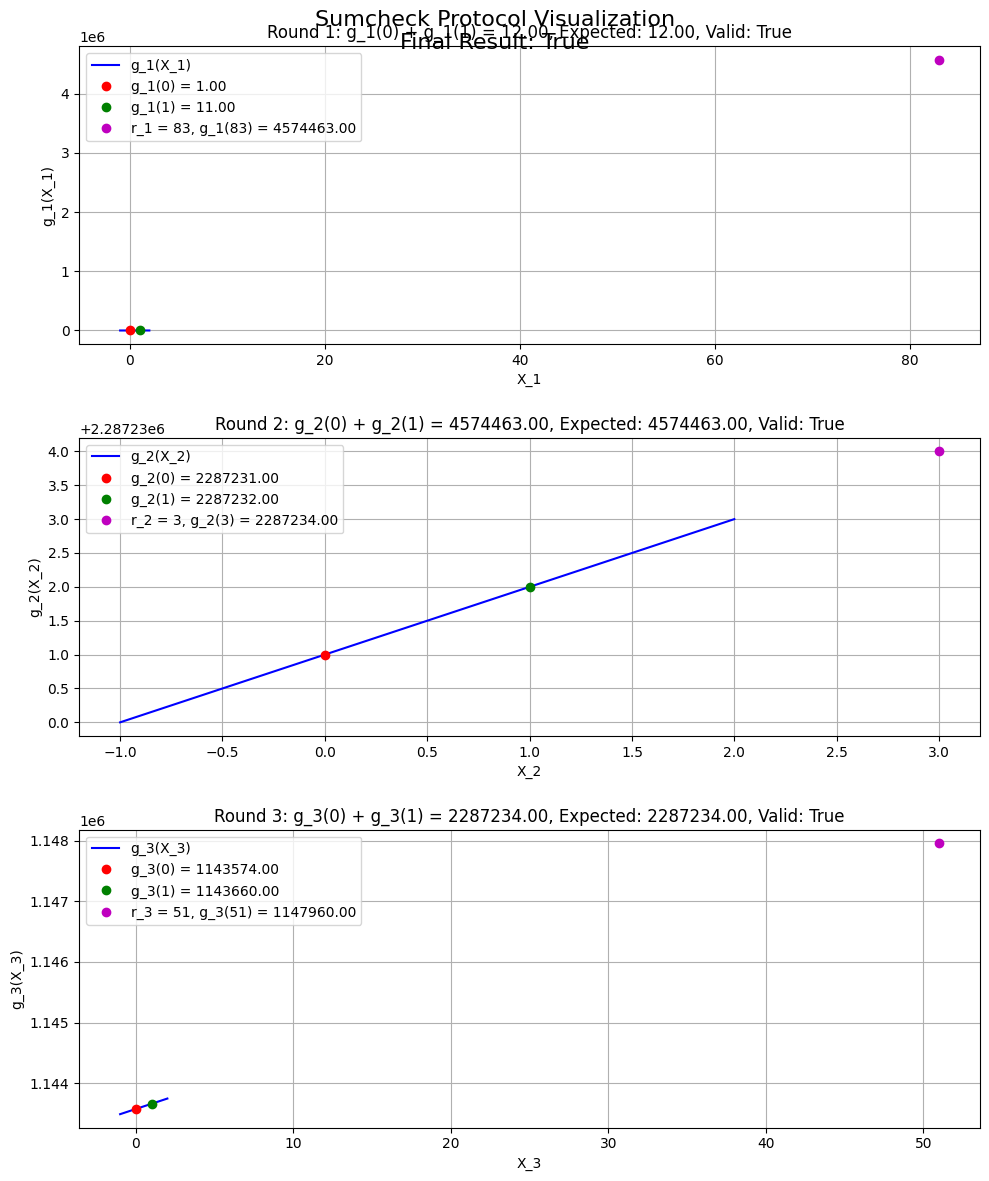


Visualizing sumcheck protocol for Polynomial 2:


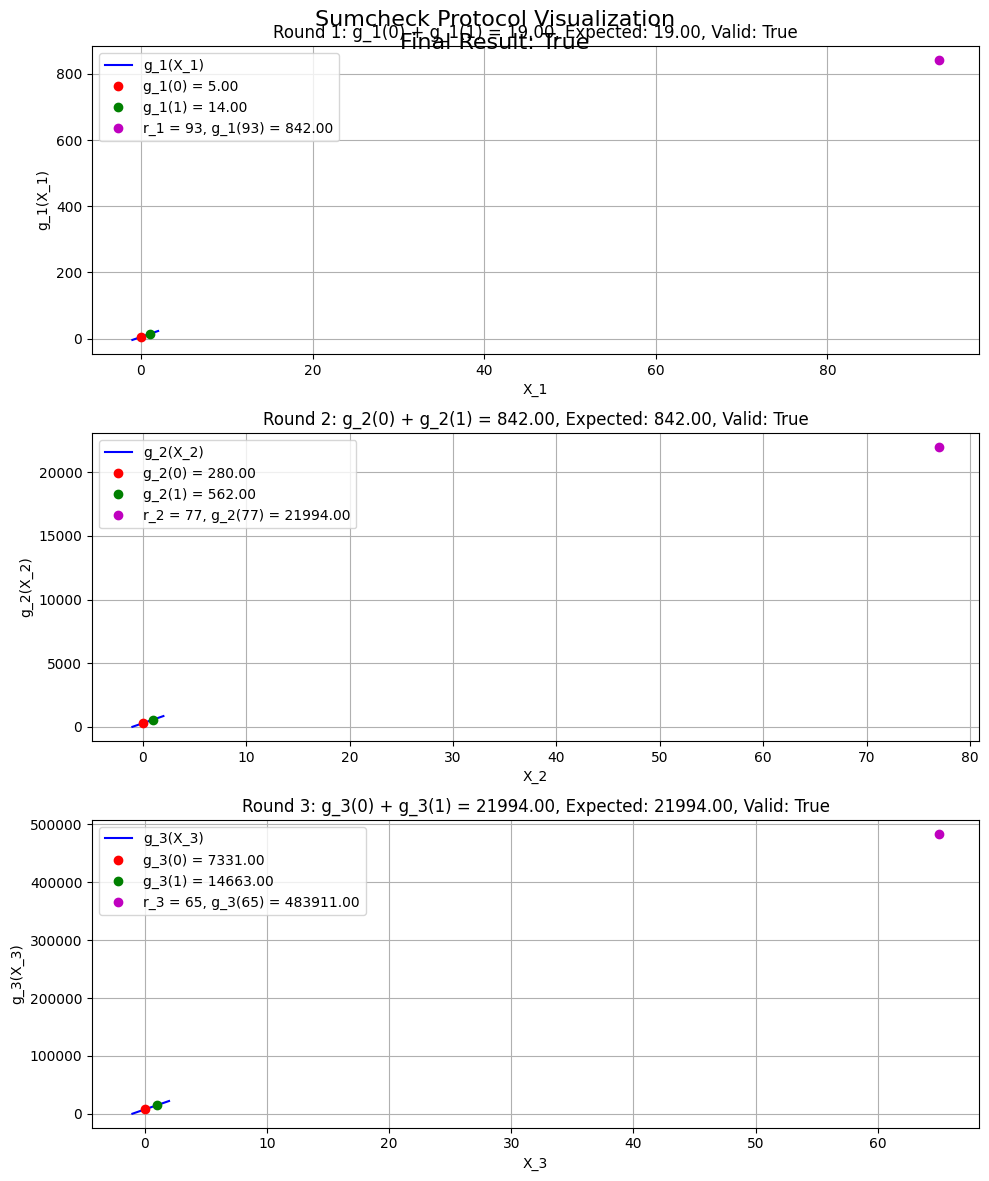

In [8]:
def visualize_sumcheck_protocol(polynomial, field_size=101):
    """
    Visualize the sumcheck protocol execution.
    
    Args:
        polynomial: The polynomial to use
        field_size: Size of the finite field for random values
    """
    n_vars = polynomial.n_vars
    
    # Compute true sum
    true_sum = compute_true_sum(polynomial)
    
    # Create prover and verifier
    prover = Prover(polynomial, true_sum)
    verifier = Verifier(polynomial, field_size)
    
    # Start protocol
    claimed_sum = prover.get_claimed_sum()
    verifier.start_protocol(claimed_sum)
    
    # Setup plotting
    n_rounds = n_vars
    fig, axs = plt.subplots(n_rounds, 1, figsize=(10, 4*n_rounds))
    if n_rounds == 1:
        axs = [axs]
    
    fixed_values = []
    previous_value = claimed_sum
    
    # Run each round
    for round_idx in range(n_vars):
        ax = axs[round_idx]
        
        # Get univariate polynomial
        uni_poly = prover.get_univariate_polynomial(round_idx, fixed_values)
        
        # Plot polynomial
        x_vals = np.linspace(-1, 2, 100)
        y_vals = [uni_poly.eval(x) for x in x_vals]
        ax.plot(x_vals, y_vals, 'b-', label=f'g_{round_idx+1}(X_{round_idx+1})')
        
        # Highlight g_i(0) and g_i(1)
        g_0 = uni_poly.eval(0)
        g_1 = uni_poly.eval(1)
        ax.plot([0], [g_0], 'ro', label=f'g_{round_idx+1}(0) = {g_0:.2f}')
        ax.plot([1], [g_1], 'go', label=f'g_{round_idx+1}(1) = {g_1:.2f}')
        
        # Verify and get random value
        valid, r_i = verifier.verify_round(uni_poly, round_idx)
        fixed_values.append(r_i)
        
        # Highlight random choice
        g_r = uni_poly.eval(r_i)
        ax.plot([r_i], [g_r], 'mo', label=f'r_{round_idx+1} = {r_i}, g_{round_idx+1}({r_i}) = {g_r:.2f}')
        
        # Show verification check
        ax.set_title(f'Round {round_idx+1}: g_{round_idx+1}(0) + g_{round_idx+1}(1) = {g_0 + g_1:.2f}, ' +
                    f'Expected: {previous_value:.2f}, Valid: {valid}')
        previous_value = g_r
        
        ax.grid(True)
        ax.legend()
        ax.set_xlabel(f'X_{round_idx+1}')
        ax.set_ylabel(f'g_{round_idx+1}(X_{round_idx+1})')
    
    # Final check
    final_value = prover.evaluate_final(fixed_values)
    final_result = verifier.final_check(final_value)
    
    plt.tight_layout()
    plt.suptitle(f'Sumcheck Protocol Visualization\nFinal Result: {final_result}', fontsize=16)
    plt.subplots_adjust(top=0.95)
    plt.show()

# Visualize the protocol for our example polynomials
print("Visualizing sumcheck protocol for Polynomial 1:")
visualize_sumcheck_protocol(poly1)

if poly2.n_vars <= 3:  # Only visualize if not too many variables
    print("\nVisualizing sumcheck protocol for Polynomial 2:")
    visualize_sumcheck_protocol(poly2)

## Analysis of the Sumcheck Protocol

Let's analyze key properties of the sumcheck protocol:

1. **Completeness**: If the claimed sum is correct and the prover follows the protocol, the verifier will always accept.

2. **Soundness**: If the claimed sum is incorrect, the verifier will reject with high probability regardless of the prover's strategy.

3. **Efficiency**: The protocol requires $n$ rounds of interaction, where $n$ is the number of variables, and each message is a univariate polynomial of degree at most $d$, where $d$ is the degree of the original polynomial.

Let's compare the efficiency of the sumcheck protocol with the naive approach of evaluating the polynomial at all $2^n$ boolean inputs.

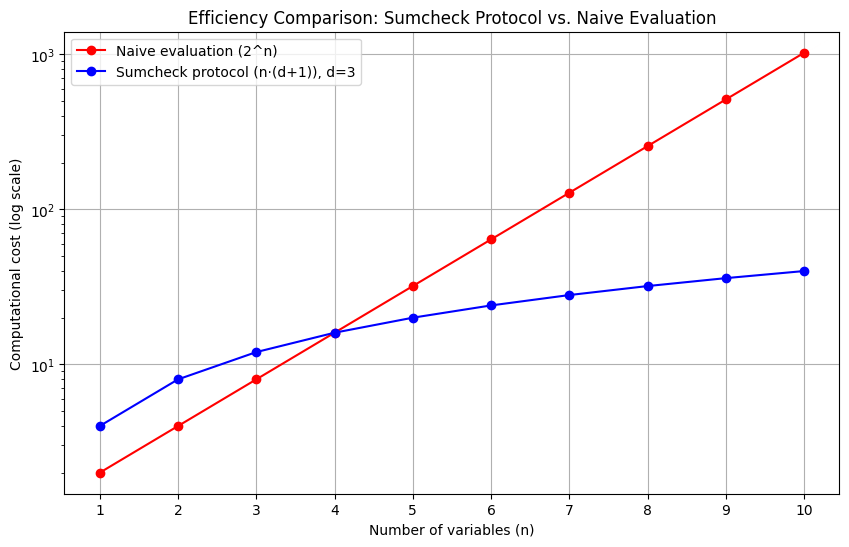

n = 1: Sumcheck is 0.50x more efficient than naive evaluation
n = 2: Sumcheck is 0.50x more efficient than naive evaluation
n = 3: Sumcheck is 0.67x more efficient than naive evaluation
n = 4: Sumcheck is 1.00x more efficient than naive evaluation
n = 5: Sumcheck is 1.60x more efficient than naive evaluation
n = 6: Sumcheck is 2.67x more efficient than naive evaluation
n = 7: Sumcheck is 4.57x more efficient than naive evaluation
n = 8: Sumcheck is 8.00x more efficient than naive evaluation
n = 9: Sumcheck is 14.22x more efficient than naive evaluation
n = 10: Sumcheck is 25.60x more efficient than naive evaluation


In [9]:
def analyze_sumcheck_efficiency(max_vars=10, max_degree=3):
    """
    Analyze and compare the efficiency of the sumcheck protocol with naive evaluation.
    
    Args:
        max_vars: Maximum number of variables to analyze
        max_degree: Degree of the polynomial to analyze
    """
    # Arrays to hold computational costs
    naive_cost = np.zeros(max_vars)  # Cost of naive evaluation
    protocol_cost = np.zeros(max_vars)  # Cost of the sumcheck protocol
    
    for n in range(1, max_vars + 1):
        # Naive approach: evaluate at all 2^n boolean inputs
        naive_cost[n-1] = 2**n
        
        # Sumcheck protocol:
        # - n rounds
        # - Each round sends a degree-d univariate polynomial (d+1 coefficients)
        # - Verifier does O(d) operations per round
        protocol_cost[n-1] = n * (max_degree + 1)
    
    # Plot the comparison
    plt.figure(figsize=(10, 6))
    plt.semilogy(range(1, max_vars + 1), naive_cost, 'ro-', label='Naive evaluation (2^n)')
    plt.semilogy(range(1, max_vars + 1), protocol_cost, 'bo-', label=f'Sumcheck protocol (n·(d+1)), d={max_degree}')
    plt.grid(True)
    plt.xlabel('Number of variables (n)')
    plt.ylabel('Computational cost (log scale)')
    plt.title('Efficiency Comparison: Sumcheck Protocol vs. Naive Evaluation')
    plt.legend()
    plt.xticks(range(1, max_vars + 1))
    plt.show()
    
    # Print the computational advantage
    for n in range(1, max_vars + 1):
        advantage = naive_cost[n-1] / protocol_cost[n-1]
        print(f"n = {n}: Sumcheck is {advantage:.2f}x more efficient than naive evaluation")

# Analyze efficiency
analyze_sumcheck_efficiency(max_vars=10, max_degree=3)

## Extensions and Applications of the Sumcheck Protocol

The sumcheck protocol forms the basis for several important results in computational complexity theory and has practical applications in verifiable computation. Some key extensions and applications include:

1. **IP = PSPACE**: The sumcheck protocol was used to prove that Interactive Proofs (IP) are as powerful as PSPACE.

2. **GKR Protocol**: The sumcheck protocol is a key component of the GKR protocol for verifiable computation.

3. **Zero-Knowledge Sumcheck**: Extensions to make the sumcheck protocol zero-knowledge, hiding the actual polynomial from the verifier.

Let's explore a simple application: using the sumcheck protocol to verify matrix multiplication.

In [10]:
def matrix_mult_as_sumcheck(n=2):
    """
    Demonstrate how matrix multiplication can be verified using the sumcheck protocol.
    
    Args:
        n: Size of the n x n matrices
    """
    # Create random n x n matrices
    A = np.random.randint(0, 10, (n, n))
    B = np.random.randint(0, 10, (n, n))
    
    # Compute C = A * B
    C = A @ B
    
    print("Matrix A:")
    print(A)
    print("\nMatrix B:")
    print(B)
    print("\nMatrix C = A * B:")
    print(C)
    
    # Explain the reduction to a sumcheck instance
    print("\nTo verify matrix multiplication using sumcheck:")
    print("1. We can express C[i,j] = Σ_{k=0}^{n-1} A[i,k] * B[k,j]")
    print("2. This sum can be verified using the sumcheck protocol")
    
    # Choose a random entry to verify
    i, j = np.random.randint(0, n, 2)
    actual_sum = C[i,j]
    
    print(f"\nVerifying entry C[{i},{j}] = {actual_sum}")
    print(f"This equals the sum: Σ_{{k=0}}^{{n-1}} A[{i},k] * B[k,{j}]")
    
    # Show the actual calculation
    terms = [f"A[{i},{k}]·B[{k},{j}] = {A[i,k]}·{B[k,j]} = {A[i,k]*B[k,j]}" for k in range(n)]
    print("\nExplicit calculation:")
    print("\n + ".join(terms))
    print(f" = {actual_sum}")
    
    # Create a polynomial representation for this sum
    x = sp.symbols('x')
    terms = [A[i,k] * B[k,j] for k in range(n)]
    
    # Create a polynomial that equals the sum when evaluated over all Boolean inputs
    poly_expr = sum(terms[k] * (1 - x) if k == 0 else terms[k] * x for k in range(min(2, n)))
    if n > 2:
        print("\nNote: For n>2, we'd need more variables to represent the full sum")
    
    if n == 2:
        poly = Polynomial(poly_expr, [x])
        print(f"\nEquivalent polynomial: {poly}")
        print(f"Sum over Boolean domain: {compute_true_sum(poly)}")
        print(f"Expected sum: {actual_sum}")

# Demonstrate matrix multiplication verification
matrix_mult_as_sumcheck(n=2)

Matrix A:
[[0 8]
 [1 6]]

Matrix B:
[[9 4]
 [6 1]]

Matrix C = A * B:
[[48  8]
 [45 10]]

To verify matrix multiplication using sumcheck:
1. We can express C[i,j] = Σ_{k=0}^{n-1} A[i,k] * B[k,j]
2. This sum can be verified using the sumcheck protocol

Verifying entry C[0,0] = 48
This equals the sum: Σ_{k=0}^{n-1} A[0,k] * B[k,0]

Explicit calculation:
A[0,0]·B[0,0] = 0·9 = 0
 + A[0,1]·B[1,0] = 8·6 = 48
 = 48

Equivalent polynomial: 48*x
Sum over Boolean domain: 48.0
Expected sum: 48


## Summary and Conclusion

In this notebook, we've implemented and explored the sumcheck protocol, a fundamental interactive proof system with applications in computational complexity theory and verifiable computation.

Key components we've covered:

1. **Protocol Structure**:
   - Prover claims the sum of a multivariate polynomial over Boolean inputs
   - Protocol proceeds in rounds, reducing the dimension by one each round
   - Verifier uses randomness to achieve high probability of correctness

2. **Implementation**:
   - Polynomial representation and evaluation
   - Honest and dishonest prover behaviors
   - Verifier checks and random challenges
   - Full protocol simulation

3. **Analysis**:
   - Efficiency compared to naive evaluation
   - Visualization of the protocol's behavior
   - Applications including matrix multiplication verification

The sumcheck protocol demonstrates a powerful principle in theoretical computer science: using interaction and randomness to efficiently verify mathematical claims with high confidence. This forms the basis for many advanced cryptographic protocols and verifiable computation systems.

In [11]:
# Final demonstration: running the protocol with increasing number of variables
def demonstrate_scaling():
    """Show how the protocol scales with increasing number of variables."""
    # Define variables
    xs = sp.symbols('x0:6')  # Create symbols x0, x1, ..., x5
    
    results = []
    
    # Try polynomials with different numbers of variables
    for n_vars in range(1, 6):
        # Create a simple multilinear polynomial with n_vars variables
        expr = sum(xs[i] for i in range(n_vars)) + prod(xs[i] for i in range(min(3, n_vars)))
        poly = Polynomial(expr, [xs[i] for i in range(n_vars)])
        
        print(f"\nTesting with {n_vars} variables")
        print(f"Polynomial: {poly}")
        
        # Measure time for naive evaluation
        start = time.time()
        true_sum = compute_true_sum(poly)
        naive_time = time.time() - start
        
        # Measure time for sumcheck protocol
        start = time.time()
        protocol_result = run_sumcheck_protocol(poly, verbose=False)
        protocol_time = time.time() - start
        
        results.append({
            'n_vars': n_vars,
            'naive_time': naive_time,
            'protocol_time': protocol_time,
            'speedup': naive_time / protocol_time
        })
        
        print(f"Naive evaluation time: {naive_time:.6f} seconds")
        print(f"Protocol time: {protocol_time:.6f} seconds")
        print(f"Speedup: {naive_time / protocol_time:.2f}x")
    
    # Create a summary table
    print("\nSummary of Performance:")
    print("----------------------------------------")
    print("Variables | Naive Time | Protocol Time | Speedup")
    print("----------------------------------------")
    for r in results:
        print(f"{r['n_vars']:9d} | {r['naive_time']:.6f} | {r['protocol_time']:.6f} | {r['speedup']:.2f}x")
    print("----------------------------------------")

# Run the scaling demonstration
demonstrate_scaling()

print("\nThis completes our implementation and analysis of the sumcheck protocol.")


Testing with 1 variables
Polynomial: 2*x0
Naive evaluation time: 0.000097 seconds
Protocol time: 0.000323 seconds
Speedup: 0.30x

Testing with 2 variables
Polynomial: x0*x1 + x0 + x1
Naive evaluation time: 0.000314 seconds
Protocol time: 0.000587 seconds
Speedup: 0.53x

Testing with 3 variables
Polynomial: x0*x1*x2 + x0 + x1 + x2
Naive evaluation time: 0.000525 seconds
Protocol time: 0.001263 seconds
Speedup: 0.42x

Testing with 4 variables
Polynomial: x0*x1*x2 + x0 + x1 + x2 + x3
Naive evaluation time: 0.000817 seconds
Protocol time: 0.003190 seconds
Speedup: 0.26x

Testing with 5 variables
Polynomial: x0*x1*x2 + x0 + x1 + x2 + x3 + x4
Naive evaluation time: 0.001818 seconds
Protocol time: 0.004926 seconds
Speedup: 0.37x

Summary of Performance:
----------------------------------------
Variables | Naive Time | Protocol Time | Speedup
----------------------------------------
        1 | 0.000097 | 0.000323 | 0.30x
        2 | 0.000314 | 0.000587 | 0.53x
        3 | 0.000525 | 0.001263

In [12]:
r1 = 3
r2 = 4
w = (1-r1)*(1-r2) + 2*(1-r1)*r2 + r1*(1-r2) + 4*(r1*r2)
a = (1-r1)*(1-r2)
b = 2*(1-r1)*r2
c = r1*(1-r2)
d = 4*(r1*r2)
print(a)
print(b)
print(c)
print(d)


6
-16
-9
48
